<a href="https://colab.research.google.com/github/nicolassalomon96/road_lane_detector/blob/main/Road_Lane_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Final - Procesamiento de Imágenes - Detector de carriles para vehículos autónomos

Nombre y Apellido: Nicolás Salomón

Email: nicolassalomon96@gmail.com

El objetivo de este TP Final es desarrollar un sistema de detección de carriles para vehículos autónomos. Para ello se hará uso de distintas técnicas de procesamiento de imagenes y transformación espaciales.

##1. Librerias necesarias

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio as io
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2. Funciones y clases creadas

In [ ]:
#Función para descargar imagen
def get_image(path):
  image = io.imread(path)
  return image.astype('uint8')

#Función para plotear una imagen
def plot_image(image, title, figsize=(10,6)):
  fig, axs = plt.subplots(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=14)


In [ ]:
class road_lane_detector():

  def __init__(self, frame):

    #frame = frame del video en RGB
    self.frame = frame
    self.width = frame.shape[1]
    self.height = frame.shape[0]
    self.gray_frame = None #Frame en escala de grises
    self.y_meters_per_pixel = 3.0/60 #metros/pixel en el eje y debe calibrarse dependiendo de la cámara
    self.x_meters_per_pixel = 3.7/450 #metros/pixel en el eje x debe calibrarse dependiendo de la cámara 

    #self.roi = np.array([(0, self.height),(540,470),(750,470),(self.width, self.height)], np.int32) # (530,470)(770,470)coordenadas para la region de interes en video: easy_video
    self.roi = np.array([(0, self.height),(570,480),(760,480),(self.width, self.height)], np.int32) #coordenadas para la region de interes en video: challenge_video
    self.dst_points = np.array([(0, self.height), (0,0), (self.width,0), (self.width, self.height)], np.float32)
    
    self.warped_image = None #Imagen resultante de aplicar la transformación de perspectiva
    self.transformation_matrix = None
    self.inverse_transformation_matrix = None
    
    self.lane_color_threshold = 600 #Umbral para determinar si la linea es amarilla o blanca
    self.left_lane_color = None
    self.left_lane_kind = None
    self.right_lane_color = None
    self.right_lane_kind = None    
    
    self.points_y = None #Puntos en el eje y para trazar la recta obtenida que representa a la linea del carril detectado
    self.left_lane = None #Puntos en el eje x para trazar la recta obtenida que representa a la linea del carril izquierdo detectado
    self.right_lane = None #Puntos en el eje x para trazar la recta obtenida que representa a la linea del carril derecho detectado

    self.left_x = None
    self.left_y = None
    self.right_x = None
    self.right_y = None

    self.left_max_pos = None #Posiciones de los maximos del histograma de carriles
    self.right_max_pos = None 

    self.sliding_window_threshold = 300 #300 #Umbral de cantidad de pixeles contados para recentrar la ventana deslizante

    self.binary_frame = None
    self.binary_warped = None
    self.sliding_window_image = None #Imagen con el resultado del algoritmo de ventanas deslizantes
    self.final_lane_mask = None #Imagen con la máscara final generada del carril
    self.result = None #Imagen final con el paso a paso

    self.curvature_radius = None #Radio de curvatura del carril
    self.center = None #Offset de la posición actual del auto con respecto al centro del carril. Negativo: el auto esta desviado hacia la derecha - Positivo: el auto esta desviado hacia la izquierda

  #Función para plotear una imagen
  def plot_image(self, image, title, figsize=(10,6)):
    fig, axs = plt.subplots(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(title, fontsize=14)

  #Función para binarizar una imagen definiendo un umbral de binarización
  def apply_threshold(self, image, lower_threshold, new_value):
    binary = image.copy()
    binary[binary > lower_threshold] = new_value
    binary[binary < lower_threshold] = 0
    return binary

  #Función para convertir una imagen RGB a escala de grises
  def rgb2gray(self):
    self.gray_frame = (0.299 * self.frame[:,:,0] + 0.587 * self.frame[:,:,1] + 0.114 * self.frame[:,:,2]).astype('uint8')
    
  #Función para prepocesar la imagen y binarizarla
  def image_threshold(self):
    self.rgb2gray()
    lum_thresh = 70
    
    if np.mean(self.gray_frame[self.height//2:,:]) < lum_thresh:
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
      image_1 = clahe.apply(self.gray_frame)
      #plot_image(image_1,'CLAHE')

      mag_thresh_value = 30
      atan_thresh_min = 0.8
      atan_thresh_max = 1.4

      #Umbral de dirección y magnitud
      sobel_x = np.absolute(cv2.Sobel(image_1, cv2.CV_64F, 1, 0, ksize=25))
      sobel_y = np.absolute(cv2.Sobel(image_1, cv2.CV_64F, 0, 1, ksize=25))

      # Magnitud
      magnitude = (sobel_x**2 + sobel_y**2)**.5
      mag_norm = np.uint8(255 * magnitude / np.max(magnitude))
      mag_thresh = np.zeros_like(mag_norm, dtype=np.uint8) 
      mag_thresh[mag_norm > mag_thresh_value] = 255
      #plot_image(mag_thresh,'SOBEL MAG')

      # Dirección
      atan = np.arctan2(sobel_y, sobel_x)
      dir_thresh = np.zeros_like(atan, dtype=np.uint8)    
      dir_thresh[(atan > atan_thresh_min) & (atan <= atan_thresh_max)] = 255
      #plot_image(dir_thresh,'SOBEL DIR')

      # Unión de ambas imágenes
      mag_and_dir = cv2.bitwise_and(mag_thresh, dir_thresh)  
      #plot_image(mag_and_dir,'mag_and_dir')
      
      #Yellow threshold
      yellow_mask = cv2.inRange(cv2.cvtColor(self.frame, cv2.COLOR_RGB2HLS), np.uint8([10, 0, 50]), np.uint8([50, 255, 200]))
      #plot_image(yellow_mask,'yellow_mask')
      
      # Unión de ambas imágenes (filtro de color y sobel)
      sobel_or_color = cv2.bitwise_or(mag_and_dir, yellow_mask)
      #plot_image(sobel_or_color,'grad_or_color')

      #Operaciones morfológicas sobre la imagen resultante
      dilatate = cv2.dilate(sobel_or_color, np.ones((5,5), np.uint8), iterations=1)
      close = cv2.erode(dilatate, np.ones((5,5), np.uint8), iterations=1)
      #plot_image(close,'cierre')

      self.binary_frame = close.copy()
    
    else:
      hls_image = cv2.cvtColor(self.frame, cv2.COLOR_RGB2HLS)
      yellow_mask = cv2.inRange(hls_image, np.uint8([10, 0, 50]), np.uint8([50, 200, 255]))
      #plot_image(yellow_mask,'YELLOW FILTER')

      gray_binary = self.apply_threshold(self.gray_frame, 180, 255)
      #plot_image(gray_binary,'GRAY')
      #plot_image(cv2.bitwise_or(yellow_mask, gray_binary),'COMBINATION')

      self.binary_frame = cv2.bitwise_or(yellow_mask, gray_binary)

  #Función para plotear la imagen demarcando la región de interés (ROI) para el procesamiento, esta region debe setearse en función de cada cámara
  def plot_roi (self):
    image_cp = np.copy(self.frame)
    image_out = cv2.polylines(image_cp, [self.roi], True, (255,0,0), thickness=2)
    self.plot_image(image_out,'ROI')

  #Función para obtener la vista de ojo de ave de la región de interés
  def get_perspective_transform(self, plot=True):

    float_roi = self.roi.astype('float32')
    #Calculamos la matriz de transformación dado los puntos iniciales y de destino
    self.transformation_matrix = cv2.getPerspectiveTransform(float_roi, self.dst_points)
    #Obtenemos la vista de ave
    self.warped_image = cv2.warpPerspective(self.frame, self.transformation_matrix, (self.width, self.height))
    self.binary_warped = cv2.warpPerspective(self.binary_frame, self.transformation_matrix, (self.width, self.height))

    if plot==True:    
      self.plot_image(self.warped_image,'Bird Eye View')

  #Función para obtener el color de las líneas derecha e izquierda de la carretera
  def get_left_right_lanecolor(self):
    #Los limites de los colores amarillo y blanco fueron fijados manualmente
    image = cv2.cvtColor(self.warped_image[self.height//3:,:], cv2.COLOR_RGB2HLS) #Se convierte a HLS para diferenciar mejor los colores

    left = image[image.shape[0]//2:image.shape[0],0:image.shape[1]//3] #Obtenemos la porción izquierda donde se encuentra la linea izquierda
    right = image[image.shape[0]//2:image.shape[0]:,(image.shape[1]//3)*2:] #Obtenemos la porción derecha donde se encuentra la linea derecha

    left_yellow_mask = cv2.inRange(left, np.uint8([10, 0,   50]), np.uint8([50, 200, 255]))
    left_yellow_mask = (left_yellow_mask > 1).nonzero()[0] #Detecto pixeles amarillos izquierda

    right_yellow_mask = cv2.inRange(right, np.uint8([10, 0, 50]), np.uint8([50, 200, 255]))
    right_yellow_mask = (right_yellow_mask > 1).nonzero()[0] #Detecto pixeles amarillos derecha

    if len(left_yellow_mask) > self.lane_color_threshold:
      self.left_lane_color = 'yellow'
    else:
      self.left_lane_color = 'white' 

    if len(right_yellow_mask) > self.lane_color_threshold:
      self.right_lane_color = 'yellow'
    else:
      self.right_lane_color = 'white' 


  #Función para obtener el histograma de la imagen y detectar donde se encuentran las lineas
  def get_histogram(self, plot=True):
    
    histogram = np.sum(self.binary_warped[2*self.height//3:self.height-50,:], axis=0)
    
    #Encontramos el pico izquierdo y derecho del histrograma
    media = int(len(histogram)/3)
    self.left_max_pos = np.argmax(histogram[:media])
    self.right_max_pos = np.argmax(histogram[2*media:]) + 2*media

    if plot==True:
      self.plot_image(self.binary_warped,'Carriles')
      plt.show()

      plt.figure(2,figsize=(10.0,5.0))
      plt.plot(histogram)
      plt.scatter(x=self.left_max_pos, y=histogram[self.left_max_pos], c='red', marker='o')
      plt.scatter(x=self.right_max_pos, y=histogram[self.right_max_pos], c='red', marker='o')
      plt.title(f'Histograma de carriles - Left max = {self.left_max_pos} - Right max = {self.right_max_pos}')
      plt.xlabel('Pixel')
      plt.show()  
 
  #Función para aplicar el algoritmo de ventana deslizante
  def sliding_window(self, left_x_saved, left_y_saved, right_x_saved, right_y_saved, plot=True):

    size = self.width // 16 #Tamaño hacia los costados de la ventana deslizante desde el centro
    n_windows = 12 #Numero de ventanas deslizantes totales (verticalmente)
    height_window = self.height // n_windows
    left_window_count = 0 #Contador de ventanas sucesivas sin pixeles blancos
    right_window_count = 0 #Contador de ventanas sucesivas sin pixeles blancos
    right_ban = 0 #Bandera para determinar cuando una linea es discontinua o no
    left_ban = 0 #Bandera para determinar cuando una linea es discontinua o no
    pixel_threshold = 600 #Umbral de cantidad de pixeles por ventana para considerar si es discontinua o no
    window_threshold = 6 #Cantidad de ventanas sucesivas con pixeles para determinar que la linea es continua

    self.sliding_window_image = np.dstack((self.binary_warped, self.binary_warped, self.binary_warped)) #imagen de salida en RGB

    # Identificamos la posicion de los pixeles que no son 0 (negro)
    nonzero_pixels = self.binary_warped.nonzero()
    nonzeroy_pixels = np.array(nonzero_pixels[0])
    nonzerox_pixels = np.array(nonzero_pixels[1])

    # Posiciones iniciales en el eje x e y al momento de comenzar a ejecutar el algoritmo de ventana deslizante, luego se actualizan
    left_x = self.left_max_pos
    right_x = self.right_max_pos

    # Listas donde se almacenarán los indices de los pixeles detectados
    left_lane_inds = []
    right_lane_inds = [] 

    pixel_threshold = 1000
    continuos_left_window_count = 0
    continuos_right_window_count = 0
    discontinuos_left_window_count = 0
    discontinuos_right_window_count = 0
    continuos_window_threshold = 4
    discontinuos_window_threshold = 2

    for window in range(n_windows):
      upside_window = self.binary_warped.shape[0] - (window + 1) * height_window
      downside_window = self.binary_warped.shape[0] - window*height_window

      left_window_leftside = (left_x - size) if (left_x - size) > 0 else 0  #borde izquierdo, ventana izquierda con control de margen
      left_window_rightside = left_x + size #borde derecho, ventana izquierda
      right_window_leftside = right_x - size #borde izquierdo, ventana derecha
      right_window_rightside = (right_x + size) if (right_x + size) < self.width else self.width  #borde izquierdo, ventana derecha con control de margen

      #Dibujamos los rectangulos en la imagen
      cv2.rectangle(self.sliding_window_image,(left_window_leftside, upside_window),(left_window_rightside, downside_window), (100,255,255), 2) 
      cv2.rectangle(self.sliding_window_image,(right_window_leftside, upside_window),(right_window_rightside, downside_window), (100,255,255), 2)
    
      #Identifico la cantidad de pixeles que no son 0 dentro de la ventana
      true_left_inds = ((nonzeroy_pixels >= upside_window) & (nonzeroy_pixels < downside_window) & (nonzerox_pixels >= left_window_leftside) & (nonzerox_pixels < left_window_rightside)).nonzero()[0]
      true_right_inds = ((nonzeroy_pixels >= upside_window) & (nonzeroy_pixels < downside_window) & (nonzerox_pixels >=  right_window_leftside) & (nonzerox_pixels < right_window_rightside)).nonzero()[0] 
      
      if len(true_left_inds) > pixel_threshold and left_ban == 0:
        discontinuos_left_window_count = 0
        continuos_left_window_count += 1
        if continuos_left_window_count == continuos_window_threshold:
          self.left_lane_kind = 'continuous'
          left_ban = 1
      elif len(true_left_inds) < pixel_threshold and left_ban == 0:
        continuos_left_window_count = 0
        discontinuos_left_window_count += 1
        if discontinuos_left_window_count == discontinuos_window_threshold:
          self.left_lane_kind = 'discontinuous'
          left_ban = 1

      if len(true_right_inds) > pixel_threshold and right_ban == 0:
        discontinuos_right_window_count = 0
        continuos_right_window_count += 1
        if continuos_right_window_count == continuos_window_threshold:
          self.right_lane_kind = 'continuous'
          right_ban = 1
      elif len(true_right_inds) < pixel_threshold and right_ban == 0:
        continuos_right_window_count = 0
        discontinuos_right_window_count += 1
        if discontinuos_right_window_count == discontinuos_window_threshold:
          self.right_lane_kind = 'discontinuous'
          right_ban = 1
    
      #Agregamos los indices a la lista
      left_lane_inds.append(true_left_inds)
      right_lane_inds.append(true_right_inds)

      #Comparamos con el threshold, si el número de pixeles es mayor, recentramos la ventana
      if len(true_left_inds) > self.sliding_window_threshold:
        left_x = np.int(np.mean(nonzerox_pixels[true_left_inds]))
      if len(true_right_inds) > self.sliding_window_threshold:        
        right_x = np.int(np.mean(nonzerox_pixels[true_right_inds]))
   
    #Concatenamos las listas de indices en una sola
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    #Extraemos las posiciones de los pixeles de las lineas
    self.left_x = nonzerox_pixels[left_lane_inds]
    self.left_y = nonzeroy_pixels[left_lane_inds] 
    self.right_x = nonzerox_pixels[right_lane_inds]
    self.right_y = nonzeroy_pixels[right_lane_inds]
    
    if len(self.left_x) == 0 or len(self.left_y) == 0 or len(self.right_x) == 0 or len(self.right_y) == 0:
      self.left_x = left_x_saved
      self.left_y = left_y_saved
      self.right_x = right_x_saved
      self.right_y = right_y_saved

      left_poly_coef = np.polyfit(left_y_saved, left_x_saved, 2)
      right_poly_coef = np.polyfit(right_y_saved, right_x_saved, 2)

      self.points_y = np.linspace(0, self.height-1, self.height)
      self.left_lane = left_poly_coef[0]*self.points_y**2 + left_poly_coef[1]*self.points_y + left_poly_coef[2]
      self.right_lane = right_poly_coef[0]*self.points_y**2 + right_poly_coef[1]*self.points_y + right_poly_coef[2]
    else: 
      #Obtenemos los coeficientes de un polinomio de grado 2 que mejor se ajuste a los pixeles blancos detectados
      left_poly_coef = np.polyfit(self.left_y, self.left_x, 2)
      right_poly_coef = np.polyfit(self.right_y, self.right_x, 2)

      self.points_y = np.linspace(0, self.height-1, self.height)
      self.left_lane = left_poly_coef[0]*self.points_y**2 + left_poly_coef[1]*self.points_y + left_poly_coef[2]
      self.right_lane = right_poly_coef[0]*self.points_y**2 + right_poly_coef[1]*self.points_y + right_poly_coef[2]

    #Obtenemos el radio de curvatura y el offset de la posición del vehículo con respecto al centro
    self.curvature_radius = self.get_curvature_and_center(self.binary_warped, self.points_y, self.left_x, self.left_y, self.right_x, self.right_y, self.y_meters_per_pixel, self.x_meters_per_pixel)
    self.center = self.get_car_offset(self.binary_warped, left_poly_coef, right_poly_coef, self.x_meters_per_pixel)

    #Si queremos mostrar las ventanas deslizantes en conjunto con las rectas calculadas, descomentar la siguiente parte:
    # left_lane_xy = []
    # right_lane_xy = []
    # for i in range(len(self.left_lane)):
    #   left_lane_xy.append([self.left_lane[i],self.points_y[i]])
    #   right_lane_xy.append([self.right_lane[i],self.points_y[i]])
    # left_lane_xy = np.array(left_lane_xy)
    # right_lane_xy = np.array(right_lane_xy)

    # left_color = (255,255,0) if self.left_lane_color == 'yellow' else (255,255,255)
    # right_color = (255,255,0) if self.right_lane_color == 'yellow' else (255,255,255)  

    # cv2.polylines(self.sliding_window_image, np.int32([left_lane_xy]), color=left_color, thickness = 3, isClosed=False)
    # cv2.polylines(self.sliding_window_image, np.int32([right_lane_xy]), color=right_color, thickness = 3, isClosed=False)
    
    # if plot == True:
    #   self.plot_image(self.sliding_window_image,'Resultado de las ventanas deslizantes')
    #   plt.show()

  #Función para calcular el offset de la posición actual del auto con respecto al centro (en [cm]). Se asume que la cámara esta centrada
  def get_car_offset(self, image, left_poly_coef, right_poly_coef, x_meters_per_pixel):
    car_center_position = image.shape[1]/2
    left_position = left_poly_coef[0] * image.shape[0]**2 + left_poly_coef[1] * image.shape[0] + left_poly_coef[2] #Posicion en x de la linea de la izquierda 
    right_position = right_poly_coef[0] * image.shape[0]**2 + right_poly_coef[1] * image.shape[0] + right_poly_coef[2] #Posicion en x de la linea de la derecha 
    lane_center_position = (left_position + right_position) / 2
    center = (car_center_position - lane_center_position) * x_meters_per_pixel * 100 #Se multiplica por 100 para tener la medida en [cm]
    return center

  #Función para calcular el radio de curvatura
  def get_curvature_and_center(self, image, points_y, left_x, left_y, right_x, right_y, y_meters_per_pixel, x_meters_per_pixel):

    #Obtenemos la ecuación de la curva considerando el mundo real (metros por pixeles)
    left_real_line = np.polyfit(left_y * y_meters_per_pixel, left_x * x_meters_per_pixel, 2)
    right_real_line = np.polyfit(left_y * y_meters_per_pixel, left_x * x_meters_per_pixel, 2)

    #Para evaluar el radio tomaremos el punto más cercano al vehículo (pixel de mas abajo) = np.max(points_y)
    left_curvature_radius = ((1+(2*left_real_line[0]*np.max(points_y) + left_real_line[1])**2)**1.5) / np.absolute(2*left_real_line[0])
    right_curvature_radius = ((1+(2*right_real_line[0]*np.max(points_y) + right_real_line[1])**2)**1.5) / np.absolute(2*right_real_line[0])
    curvature_radius = (left_curvature_radius + right_curvature_radius)/2
    return curvature_radius

  #Función para obtener la vista original (inversa de la vista de ojo de ave)
  def get_perspective_inverse_transform(self):
    float_roi = self.roi.astype('float32')
    self.inverse_transformation_matrix = cv2.getPerspectiveTransform(self.dst_points, float_roi)

  #Función para obtener la máscara final que demarca el carril
  def get_final_lane_mask(self, plot=True):

    self.final_lane_mask = np.zeros((self.height, self.width)).astype(np.uint8)
    self.final_lane_mask = np.dstack((self.final_lane_mask, self.final_lane_mask, self.final_lane_mask))

    #Acomodamos los puntos x e y en el formato adecuado para cv2.fillPoly()
    left_lane_recast = np.array([np.transpose(np.vstack([self.left_lane, self.points_y]))])
    right_lane_recast = np.array([np.flipud(np.transpose(np.vstack([self.right_lane, self.points_y])))])
    left_right_pts = np.hstack((left_lane_recast, right_lane_recast)).astype(int)

    #Generamos la máscara
    cv2.fillPoly(self.final_lane_mask, left_right_pts, (0,255, 0))
    
    #Llevamos la máscara a la vista "real" del auto
    self.get_perspective_inverse_transform()
    self.final_lane_mask = cv2.warpPerspective(self.final_lane_mask, self.inverse_transformation_matrix, (self.width, self.height))

    if plot == True:
      self.plot_image(self.final_lane_mask,'Final Road Lane Mask')

  #Función para obtener la imagen final (con los resultados anteriores en una sola imagen)
  def plot_result(self, plot_mask = True, plot_results = True):
    self.result = cv2.addWeighted(self.frame, 1, self.final_lane_mask, 0.3, 0)
    if plot_mask == True:
      self.plot_image(self.result,'Imagen original con su máscara')

    warped_reduced = cv2.resize(self.warped_image, (self.frame.shape[1]//4,self.frame.shape[0]//3))
    cv2.putText(warped_reduced, 'Bird Eye View', (warped_reduced.shape[1]//3 - 10, warped_reduced.shape[0]-30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    sliding_window_reduced = cv2.resize(self.sliding_window_image, (self.frame.shape[1]//4,self.frame.shape[0]//3))
    cv2.putText(sliding_window_reduced, 'Sliding Window', (sliding_window_reduced.shape[1]//3 - 10, sliding_window_reduced.shape[0]-30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    final_mask_reduced = cv2.resize(self.final_lane_mask, (self.frame.shape[1]//4,self.frame.shape[0]//3))
    cv2.putText(final_mask_reduced, 'Final Lane Mask', (final_mask_reduced.shape[1]//3 - 0, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    image_views = np.hstack((warped_reduced,sliding_window_reduced,final_mask_reduced))
    self.result[0:image_views.shape[0],0:image_views.shape[1]] = image_views[:,:]
    cv2.putText(self.result, f'Right: {self.right_lane_color}-{self.right_lane_kind}', (self.result.shape[1] - self.result.shape[1]//4 + 5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    cv2.putText(self.result, f'Left: {self.left_lane_color}-{self.left_lane_kind}', (self.result.shape[1] - self.result.shape[1]//4 + 5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    cv2.putText(self.result, f'Curvature radius: {round(self.curvature_radius,2)}[m]', (self.result.shape[1] - self.result.shape[1]//4 + 5, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.54, (255,255,255), 1)
    cv2.putText(self.result, f'Center: {round(self.center,2)}[cm]', (self.result.shape[1] - self.result.shape[1]//4 + 5, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    
    if plot_results == True:
      self.plot_image(self.result,'Resultado Final',figsize=(15,10))

##3. Prueba en Imagen

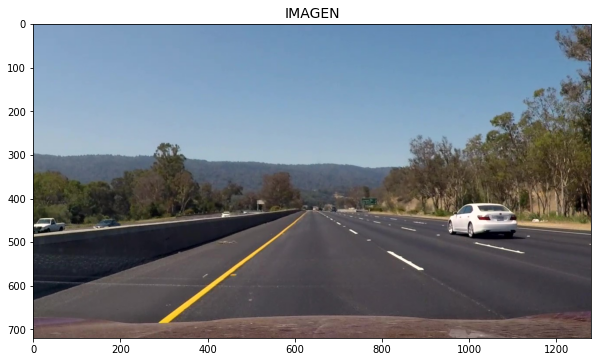

In [ ]:
link = '/content/drive/MyDrive/Posgrado/road_lane_detection/test_images/road_lane_example.jpg'
image = get_image(link)
plot_image(image,'IMAGEN')

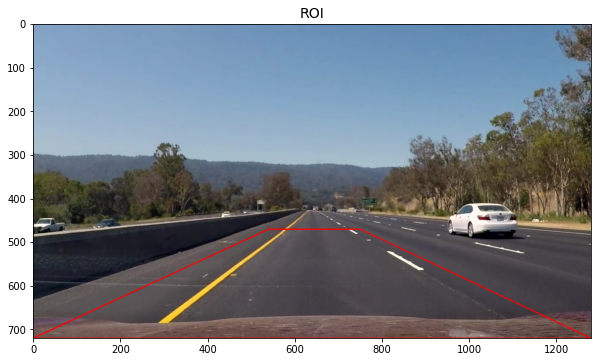

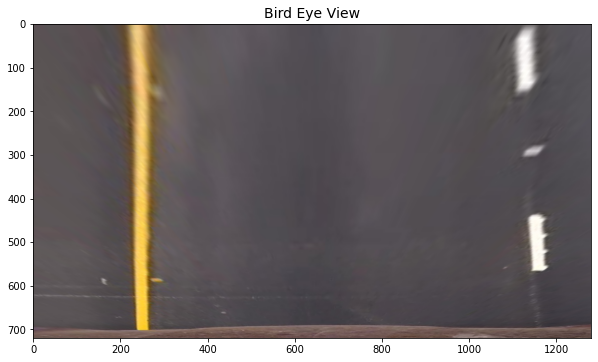

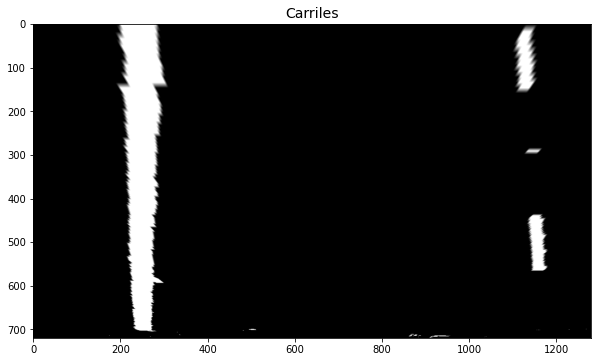

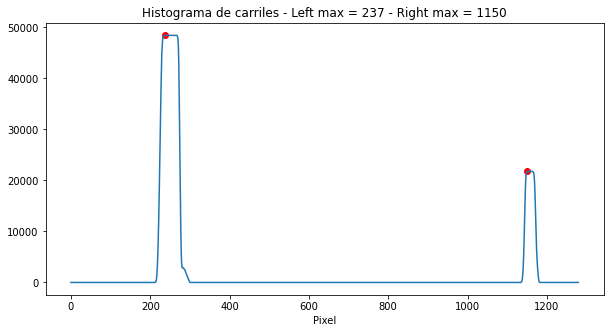

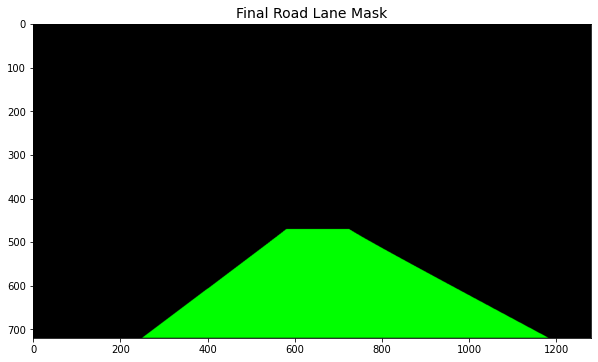

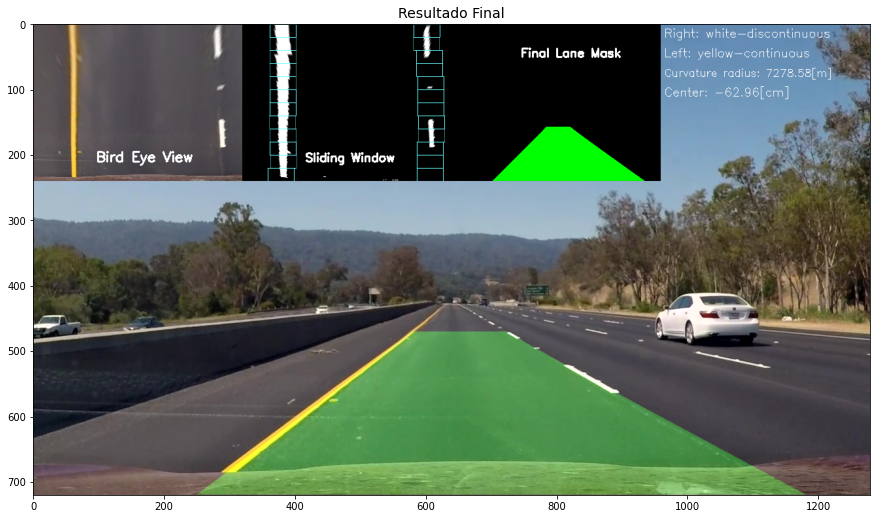

In [ ]:
lane = road_lane_detector(image)
lane.image_threshold()
lane.plot_roi()
lane.get_perspective_transform(plot=True)
lane.get_left_right_lanecolor()
lane.get_histogram(plot=True)
left_x_saved, left_y_saved, right_x_saved, right_y_saved = 0,0,0,0
lane.sliding_window(left_x_saved, left_y_saved, right_x_saved, right_y_saved, plot=True)
left_x_saved, left_y_saved, right_x_saved, right_y_saved = lane.left_x, lane.left_y, lane.right_x, lane.right_y
lane.get_final_lane_mask(plot=True)
lane.plot_result(plot_mask=False, plot_results=True)

##4. Prueba en Video

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Posgrado/road_lane_detection/test_videos/challenge_video.mp4')
ancho = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #Ancho de cada frame del video
alto = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #Alto de cada frame del video

#Salida de video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('output.avi', fourcc, 25, (ancho,alto))

left_x_saved, left_y_saved, right_x_saved, right_y_saved = 0,0,0,0

while (cap.isOpened()):
  check, frame = cap.read()
  if check == True:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
    #prev_time = time.time()

    lane_detector = road_lane_detector(frame_rgb)
    lane_detector.image_threshold()
    lane_detector.get_perspective_transform(plot=False)
    lane_detector.get_left_right_lanecolor()
    lane_detector.get_histogram(plot=False)
    lane_detector.sliding_window(left_x_saved, left_y_saved, right_x_saved, right_y_saved, plot=False)
    left_x_saved, left_y_saved, right_x_saved, right_y_saved = lane_detector.left_x, lane_detector.left_y, lane_detector.right_x, lane_detector.right_y
    lane_detector.get_final_lane_mask(plot=False)
    lane_detector.plot_result(plot_mask=False, plot_results=False)

    #finish_time = time.time()
    #print(f'Procesamiento de un frame: {finish_time - prev_time}')
    out.write(cv2.cvtColor(lane_detector.result, cv2.COLOR_RGB2BGR))
  else:
      break

print("Video procesado")
cap.release()
out.release()
cv2.destroyAllWindows()

Video procesado


In [ ]:
!cp '/content/output.avi' '/content/drive/MyDrive/Posgrado'